# **Laptop Price**

# **Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.impute import KNNImputer
from scipy import stats

# โหลดข้อมูล
df = pd.read_csv("laptops.csv")

# เติมค่า missing values - using direct assignment
df['Storage type'] = df['Storage type'].fillna('Unknown')
df['Screen'] = df['Screen'].fillna(df['Screen'].median())
df['GPU'] = df['GPU'].fillna('No GPU')

# เติมค่าขาดหายด้วย KNN Imputation
imputer = KNNImputer(n_neighbors=5)  # Initialize KNNImputer
df[['Storage', 'Screen']] = imputer.fit_transform(df[['Storage', 'Screen']])

# จัดการ Outliers
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
# กำจัดข้อมูลที่ z-score > 3
df_no_outliers = df[(z_scores < 3).all(axis=1)].copy()  # ทำให้เป็น copy เพื่อหลีกเลี่ยง warning

# แปลงข้อมูลที่เป็นข้อความให้เป็นตัวเลข
label_encoders = {}
categorical_columns = ["Brand", "CPU", "GPU", "Storage type", "Touch"]
for col in categorical_columns:
    le = LabelEncoder()
    df_no_outliers[col] = le.fit_transform(df_no_outliers[col].astype(str))
    label_encoders[col] = le

# สร้างฟีเจอร์ใหม่
df_no_outliers['Price_per_GB'] = df_no_outliers['Final Price'] / df_no_outliers['Storage']
df_no_outliers['Screen_to_Storage_Ratio'] = df_no_outliers['Screen'] / df_no_outliers['Storage']

# **พัฒนาโมเดล Machine Learning**

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mean Squared Error (MSE): 4920.67
Root Mean Squared Error (RMSE): 70.15
Mean Absolute Error (MAE): 18.18
R² Score: 0.9927


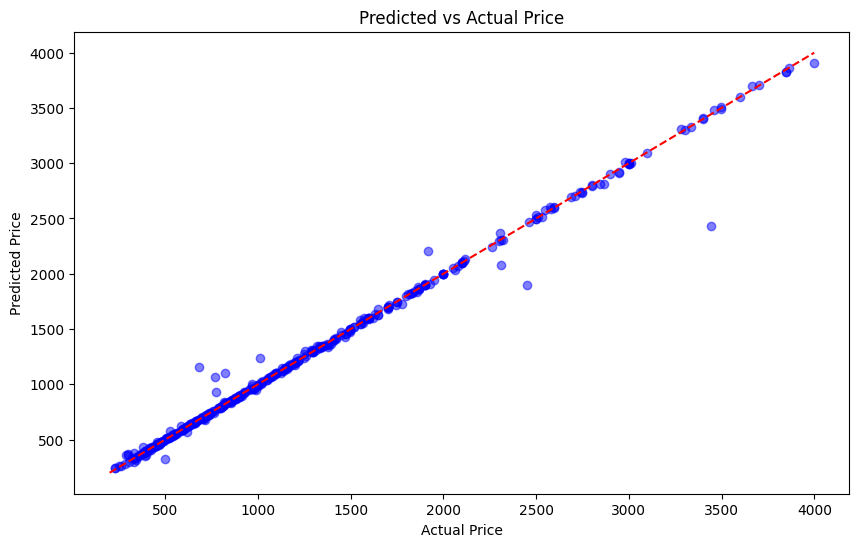

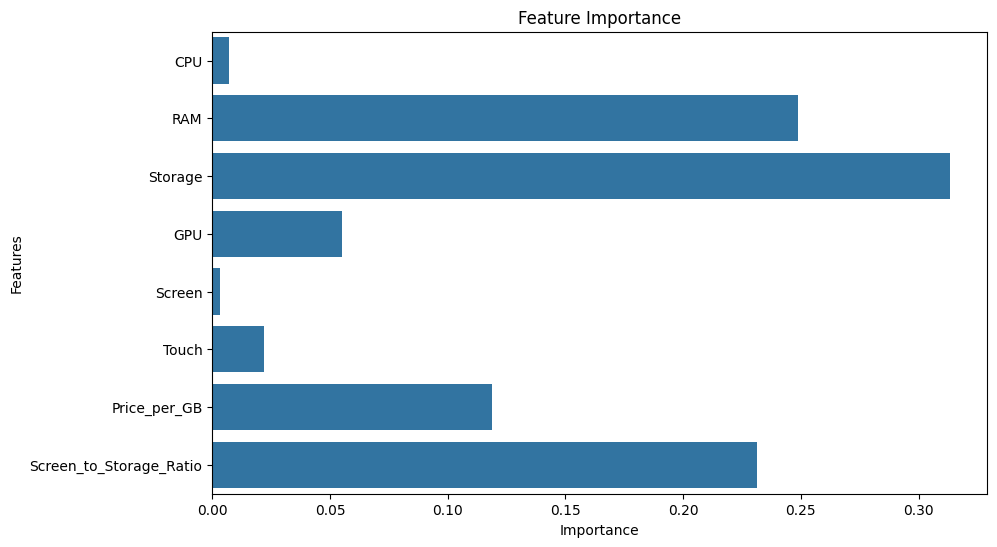

In [2]:
# แยก Features (X) และ Target (y)
X = df_no_outliers.drop(columns=["Final Price", "Laptop", "Model", "Status", "Storage type" ,"Brand" ])
y = df_no_outliers["Final Price"]

# แบ่งชุดข้อมูลเป็น Train และ Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# การปกติข้อมูล (Feature Scaling) - ใช้ PowerTransformer
scaler = PowerTransformer()
# Replace infinite values with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
# Impute NaN values (if any) with the median
X_train = X_train.fillna(X_train.median())
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ปรับพารามิเตอร์ XGBoost ด้วย RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# สร้างโมเดล XGBoost
model = XGBRegressor(random_state=42)

# ใช้ RandomizedSearchCV สำหรับการปรับพารามิเตอร์
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1, random_state=42)

# ฟิตโมเดลด้วยข้อมูลฝึก
random_search.fit(X_train_scaled, y_train)

# สร้างโมเดลใหม่จากค่าพารามิเตอร์ที่ดีที่สุด
best_model = random_search.best_estimator_

# สร้างโมเดล Stacking
base_learners = [
    ('xgb', XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
meta_learner = RidgeCV()
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)

# ฝึกโมเดล Stacking
stacking_model.fit(X_train_scaled, y_train)

# ทำนายผล
y_pred = stacking_model.predict(X_test_scaled)

# คำนวณค่าวัดผล
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# แสดงผลลัพธ์
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=best_model.feature_importances_, y=X.columns)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [3]:
print(df.columns)

Index(['Laptop', 'Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage',
       'Storage type', 'GPU', 'Screen', 'Touch', 'Final Price'],
      dtype='object')


In [6]:
!pip install joblib
import joblib # Import the joblib library

with open('stacking_model.pkl', 'wb') as f:  # Use 'wb' for writing in binary mode
    joblib.dump(stacking_model, f)

# ... (Later, when you want to load the model) ...
with open('stacking_model.pkl', 'rb') as f:  # Use 'rb' for reading in binary mode
    stacking_model = joblib.load(f)

# **พัฒนาโมเดล Neural Network**

# **Preprocess**

In [7]:
import pandas as pd

# โหลดข้อมูล
file_path = "Life Expectancy Data.csv"
df = pd.read_csv(file_path)

# ตรวจสอบข้อมูลหาย
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# เติมค่าที่หายไป
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])  # ใช้ค่าที่พบบ่อยที่สุดสำหรับข้อความ
    else:
        df[col] = df[col].fillna(df[col].median())  # ใช้ค่ามัธยฐานสำหรับตัวเลข

# แปลงข้อมูลประเภทตัวอักษรให้เป็นตัวเลข
if 'Status' in df.columns:
    df['Status'] = df['Status'].map({'Developing': 0, 'Developed': 1})

# ตรวจสอบข้อมูลหลังการทำความสะอาด
print("\nData Types:\n", df.dtypes)
print("\nMissing Values After Cleaning:\n", df.isnull().sum().sum())

# บันทึกข้อมูลที่เตรียมแล้ว
cleaned_file_path = "Life_Expectancy_Cleaned.csv"
df.to_csv(cleaned_file_path, index=False)
print("\nCleaned dataset saved to:", cleaned_file_path)

Missing Values:
 Life expectancy                     10
Adult Mortality                     10
Alcohol                            194
Hepatitis B                        553
 BMI                                34
Polio                               19
Total expenditure                  226
Diphtheria                          19
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

Data Types:
 Country                             object
Year                                 int64
Status                               int64
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                

# **Neural Network**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 65.0384 - mae: 65.5383 - val_loss: 25.0556 - val_mae: 25.5527 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 16.6080 - mae: 17.1021 - val_loss: 6.3512 - val_mae: 6.8373 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.0300 - mae: 8.5174 - val_loss: 4.6056 - val_mae: 5.0858 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8949 - mae: 7.3798 - val_loss: 4.3959 - val_mae: 4.8768 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6121 - mae: 7.0976 - val_loss: 3.4786 - val_mae: 3.9479 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2273 - mae: 6.7110 - val_loss: 3.2724 - val_mae: 3.7429 - learning_rate: 0.0010
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.0152 - mae: 6.4955 - val_loss: 2.8636 - val_mae: 3.3393 - learning_rate: 0.0010


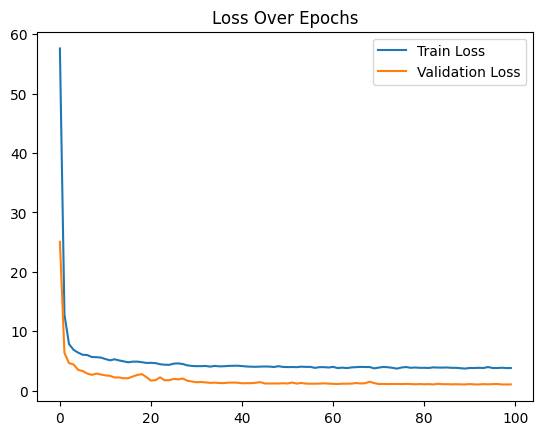

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer  # Import ColumnTransformer
import matplotlib.pyplot as plt

# โหลดข้อมูลที่เตรียมไว้
file_path = "Life_Expectancy_Cleaned.csv"
df = pd.read_csv(file_path)

# กำหนด Features และ Target
X = df.drop(columns=["Life expectancy "])
y = df["Life expectancy "]

# แบ่งข้อมูล Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# แยกคอลัมน์ตัวเลขและคอลัมน์หมวดหมู่
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# สร้าง preprocessor ด้วย ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# แปลงข้อมูล
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# สร้างโมเดล Neural Network
model = keras.Sequential([
    layers.Dense(256, activation='leaky_relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='leaky_relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dense(1)  # Regression output
])

# คอมไพล์โมเดล
# Changed 'huber_loss' to keras.losses.Huber()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.Huber(), metrics=['mae'])

# ใช้ Early Stopping และ ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

# เทรนโมเดล
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_data=(X_test_scaled, y_test), verbose=1, callbacks=callbacks)

# ทำนายผลลัพธ์
y_pred = model.predict(X_test_scaled)

# คำนวณค่าความแม่นยำ
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Neural Network - MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}")


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()



In [9]:
from tensorflow.keras.models import load_model

# สมมติว่าคุณมีโมเดลที่ฝึกแล้ว
# โมเดลที่ฝึกแล้ว (model) สามารถบันทึกเป็นไฟล์ .keras ได้
model.save('life_expectancy_model.keras')


In [10]:
print(df.columns)


Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')
